# Characterizing the Hypergraph-of-Entity with TF-Bins

This representation model uses a weighted mixed hypergraph. Dependending on the version, the weights can be unitary constants. All versions combine directed and undirected hyperedges.

Possible node classes include:

- TermNode
- EntityNode

Possible hyperedge classes include:

- DocumentEdge
- ContainedInEdge
- RelatedToEdge
- SynonymEdge
- ContextEdge

In order to run the notebook, you must first obtain the corresponding CSV files through the `inspect` command in Army ANT. For example:

```bash
./army-ant.py inspect \
    --index-location=/opt/army-ant/indexes/inex-2009-10t-nl/hgoe \
    --index-type=hgoe \
    --workdir=/opt/army-ant/analysis/inex_2009_10t_nl-stats \
    --feature=export-node-degrees
```

You must then put the resulting files into the `data` directory for the collection and index version. For example `data/inex_2009_10t_nl/base_model` for the Hypergraph-of-Entity Base Model over the INEX 2009 3T-NL subset test collection. You should then configure the `base_dir` below accordingly. Bash scripts are provided in directory `runs/inex-2009-10t-nl/hgoe/nb-characterization`, in order to generate the required files.

In [83]:
if (!require("pacman")) install.packages("pacman")

pacman::p_load(
    logging,
    ggplot2,
    scales,
    repr,
    stringr,
    dplyr,
    xtable
)

basicConfig()
options(warn=-1)
options(scipen=0)
options(xtable.include.rownames=FALSE)

base_dir <- "data/inex_2009_10t_nl/tf_bins"

## Node degree and hyperedge cardinality distributions

We define a degree data loading function for a given `base_dir`, beautifying the node and hyperedge type labels (i.e., transforming from the Java class identifier to the node or hyperedge label used in the theory).

In [84]:
load_node_degree_data <- function(base_dir) {
    nodes_path <- file.path(base_dir, list.files(path = base_dir, pattern = "node-degree-.*\\.csv"))

    nodes <- setNames(
        read.csv(nodes_path, stringsAsFactors = F),
        c("node_id", "type", "name", "v_degree", "e_degree", "in_v_degree", "out_v_degree",
          "in_e_degree", "out_e_degree", "dir_in_v_degree", "dir_out_v_degree",
          "dir_in_e_degree", "dir_out_e_degree"))
    
    nodes[which(nodes$type == "EntityNode"), "type"] <- "entity"
    nodes[which(nodes$type == "TermNode"), "type"] <- "term"
 
    nodes
}

load_edge_cardinality_data <- function(base_dir) {
    edges_path <- file.path(base_dir, list.files(path = base_dir, pattern = "edge-cardinality-.*\\.csv"))

    edges <- setNames(
        read.csv(edges_path, stringsAsFactors = F),
        c("edge_id", "type", "is_directed", "cardinality", "undirected_cardinality",
          "tail_cardinality", "head_cardinality"))
    
    edges$is_directed <- edges$is_directed == "true"
    
    edges[which(edges$type == "DocumentEdge"), "type"] <- "document"
    edges[which(edges$type == "ContainedInEdge"), "type"] <- "contained_in"
    edges[which(edges$type == "RelatedToEdge"), "type"] <- "related_to"
    edges[which(edges$type == "SynonymEdge"), "type"] <- "synonym"
    edges[which(edges$type == "ContextEdge"), "type"] <- "context"
    edges[which(edges$type == "TFBinEdge"), "type"] <- "tf_bin"
 
    edges
}

A hypergraph has two degree distributions, one for the nodes and another one for the hyperedges. We look at both.

In [85]:
bin_dirs <- list.files(base_dir)

In [92]:
node_degree <- lapply(file.path(base_dir, bin_dirs, "global"), load_node_degree_data)
names(node_degree) <- bin_dirs
node_degree <- do.call(rbind, node_degree)
node_degree$bin_id <- sapply(str_split(row.names(node_degree), "\\."), `[`, 1)
row.names(node_degree) <- NULL

In [93]:
head(node_degree)

node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree,bin_id
<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
0,entity,Pyotr Ilyich Tchaikovsky,21002,107,21002,21002,107,106,2,0,1,0,bins_02
1,entity,Central Industrial Security Force,1791,5,1791,1791,5,4,1,0,1,0,bins_02
2,entity,Mao Asada,1778,9,1778,1778,9,8,2,0,1,0,bins_02
3,entity,List of people from Saint Petersburg,3659,4,3659,3657,4,3,5,0,1,0,bins_02
4,entity,Mily Balakirev,8232,13,8232,8232,13,12,1,0,1,0,bins_02
5,entity,Ernst Moritz Arndt,3236,5,3236,3236,5,4,3,0,1,0,bins_02


In [94]:
edge_cardinality <- lapply(file.path(base_dir, bin_dirs, "global"), load_edge_cardinality_data)
names(edge_cardinality) <- bin_dirs
edge_cardinality <- do.call(rbind, edge_cardinality)
edge_cardinality$bin_id <- sapply(str_split(row.names(edge_cardinality), "\\."), `[`, 1)
row.names(edge_cardinality) <- NULL

In [201]:
head(edge_cardinality)

edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality,bin_id
<int>,<chr>,<lgl>,<int>,<int>,<int>,<int>,<chr>
0,document,FALSE,853,853,0,0,bins_02
1,document,FALSE,404,404,0,0,bins_02
2,document,FALSE,364,364,0,0,bins_02
3,document,FALSE,755,755,0,0,bins_02
4,related_to,FALSE,20,20,0,0,bins_02
5,related_to,FALSE,181,181,0,0,bins_02


In [96]:
edge_cardinality %>%
    group_by(type, bin_id) %>%
    summarise(max_cardinality=max(cardinality))

type,bin_id,max_cardinality
<chr>,<chr>,<int>
contained_in,bins_02,16
contained_in,bins_03,16
contained_in,bins_04,16
contained_in,bins_05,16
contained_in,bins_06,16
contained_in,bins_07,16
contained_in,bins_08,16
contained_in,bins_09,16
contained_in,bins_10,16


We define a degree plotting function that takes the raw CSV, calculates the degree frequency and displays a point plot with a facet for each node or hyperedge type.

In [217]:
plot_degree_per_type <- function(data, label, name="degree") {
    data <- data %>%
        count(bin_id, type, !!sym(name), sort=TRUE)
    
    ggplot(data, aes_string(x=name, y="n")) +
        facet_grid(bin_id~type) +
        geom_point(size=0.5) +
        scale_x_log10() + 
        scale_y_log10(limits=c(1,max(data$Freq))) +
        xlab(label) +
        ylab("Frequency")
}

### Node degree distributions

As we can see, the node node degree distribution in the hypergraph-of-entity does not follow a power law, despite having a long tail.

In [195]:
options(repr.plot.width=4.5, repr.plot.height=10)

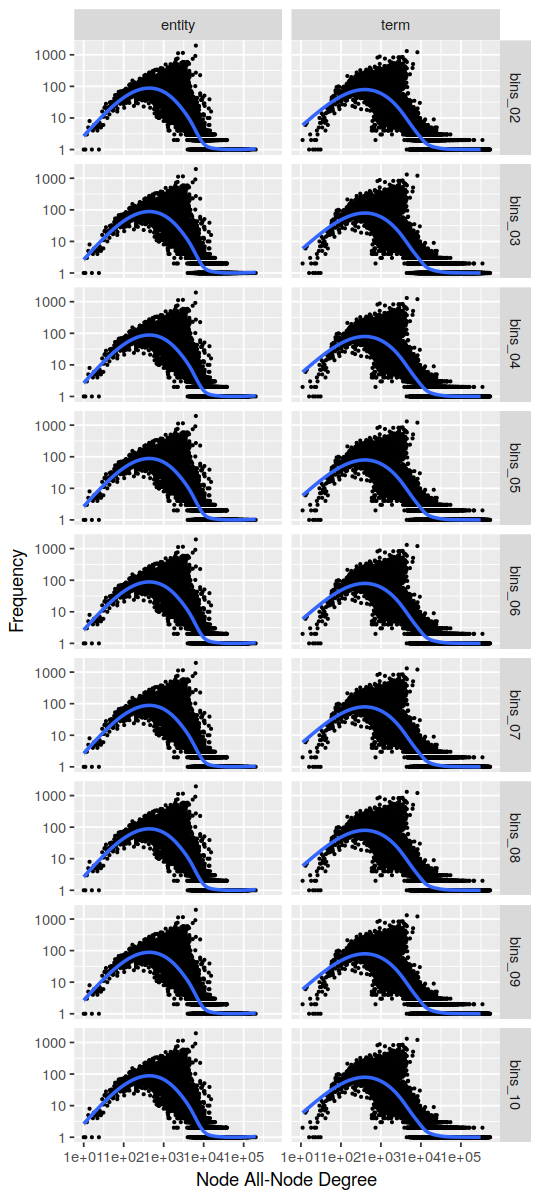

In [187]:
plot_degree_per_type(node_degree, "Node All-Node Degree", "v_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/tf_bins/node_all_node_degree.png", width = 4.5, height = 10, dpi = 300)

However, the hyperedge node degree distribution, slightly approximates a power law.

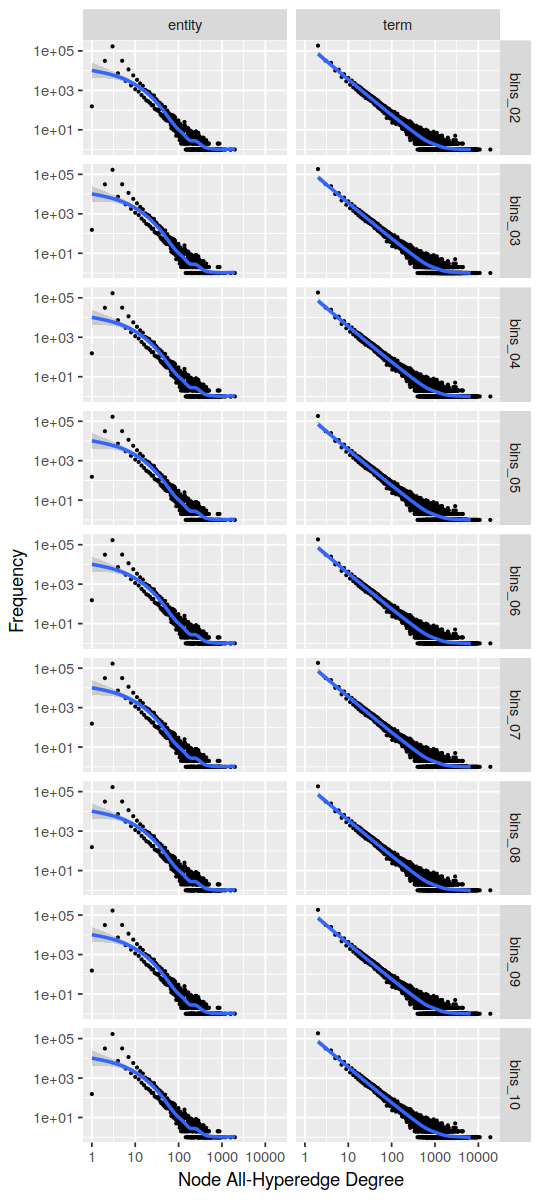

In [188]:
plot_degree_per_type(node_degree, "Node All-Hyperedge Degree", "e_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/tf_bins/node_all_hyperedge_degree.png", width = 4.5, height = 10, dpi = 300)

#### Node degree distributions based on directed hyperedges

If we only consider directed hyperedges, the node incoming-node degree does not follow a power law.

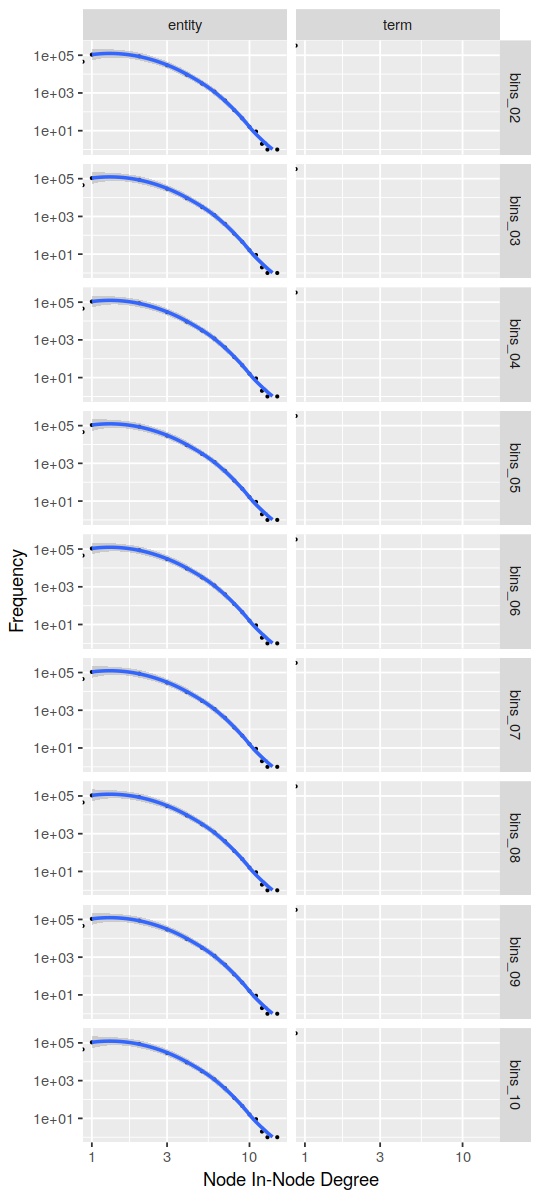

In [196]:
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Node Degree", "dir_in_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree approximates a power law, although it is more heavy-tailed.

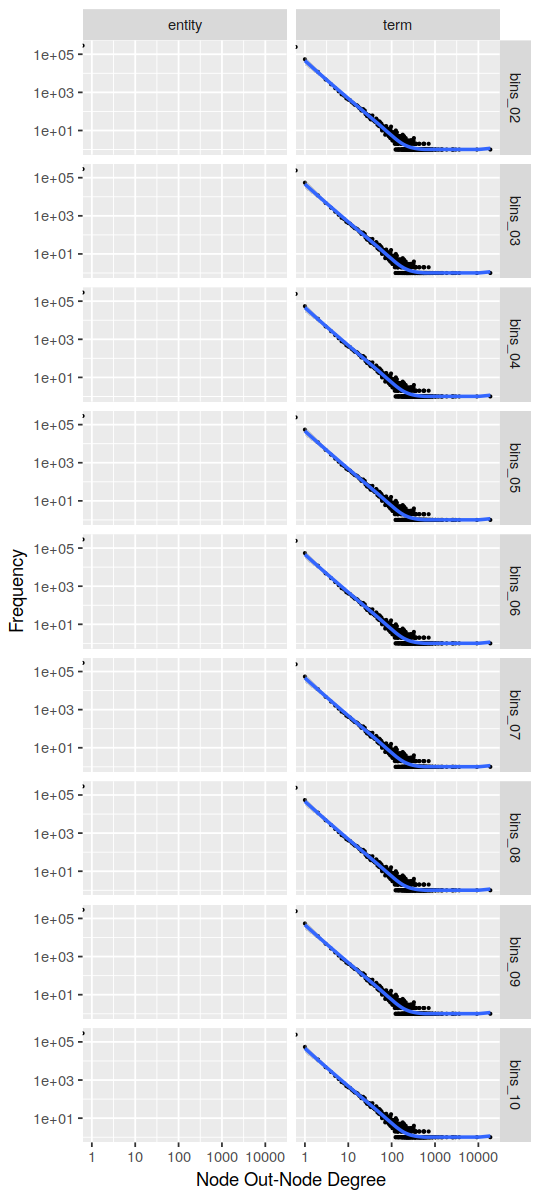

In [197]:
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Node Degree", "dir_out_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node incoming-hyperedge degree is always one.

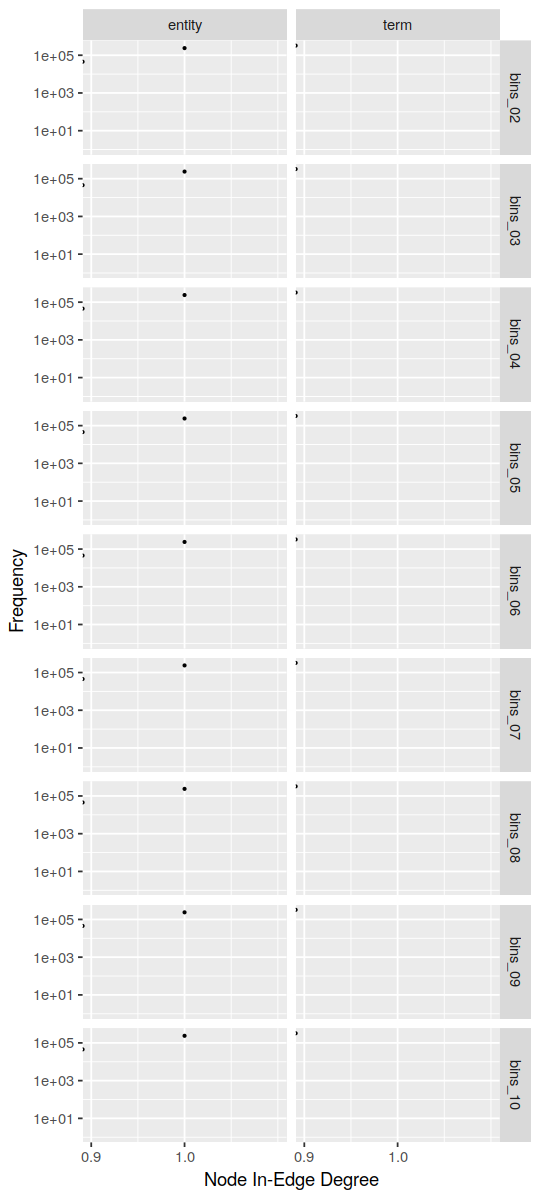

In [198]:
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Edge Degree", "dir_in_e_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree, approximates a power law, although it is more heavy-tailed.

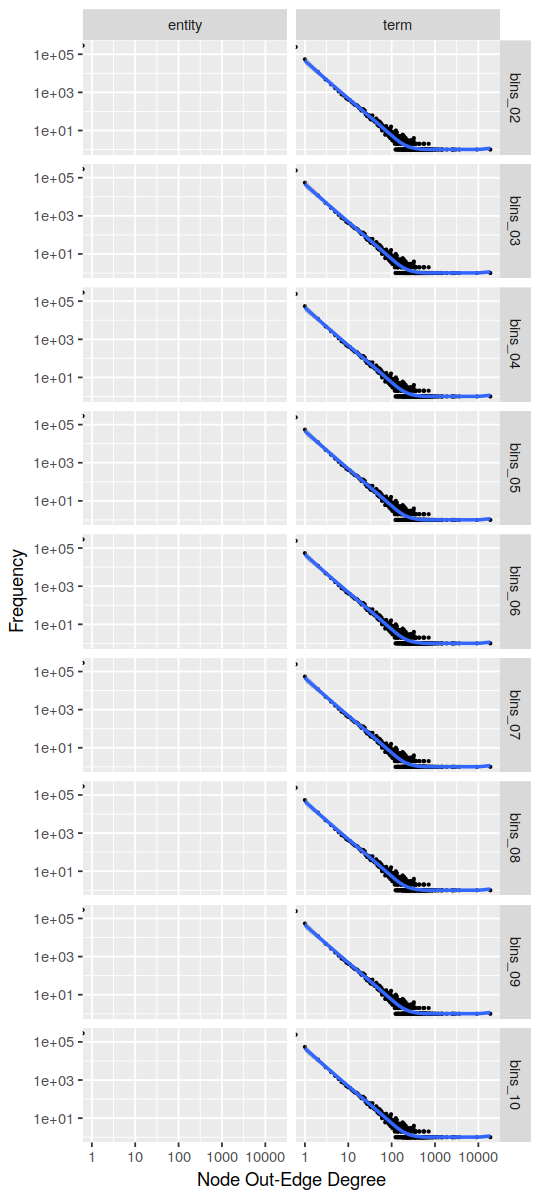

In [199]:
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Edge Degree", "dir_out_e_degree") +
    stat_smooth(method = "loess")

### Hyperedge cardinality distributions

The hyperedge cardinality distributions do not follow power laws, with the `contained_in` hyperedges having less nodes than `document` or `related_to` hyperedges. This is expected, as `contained_in` hyperedges usually link a few `term` nodes to its corresponding `entity` node.

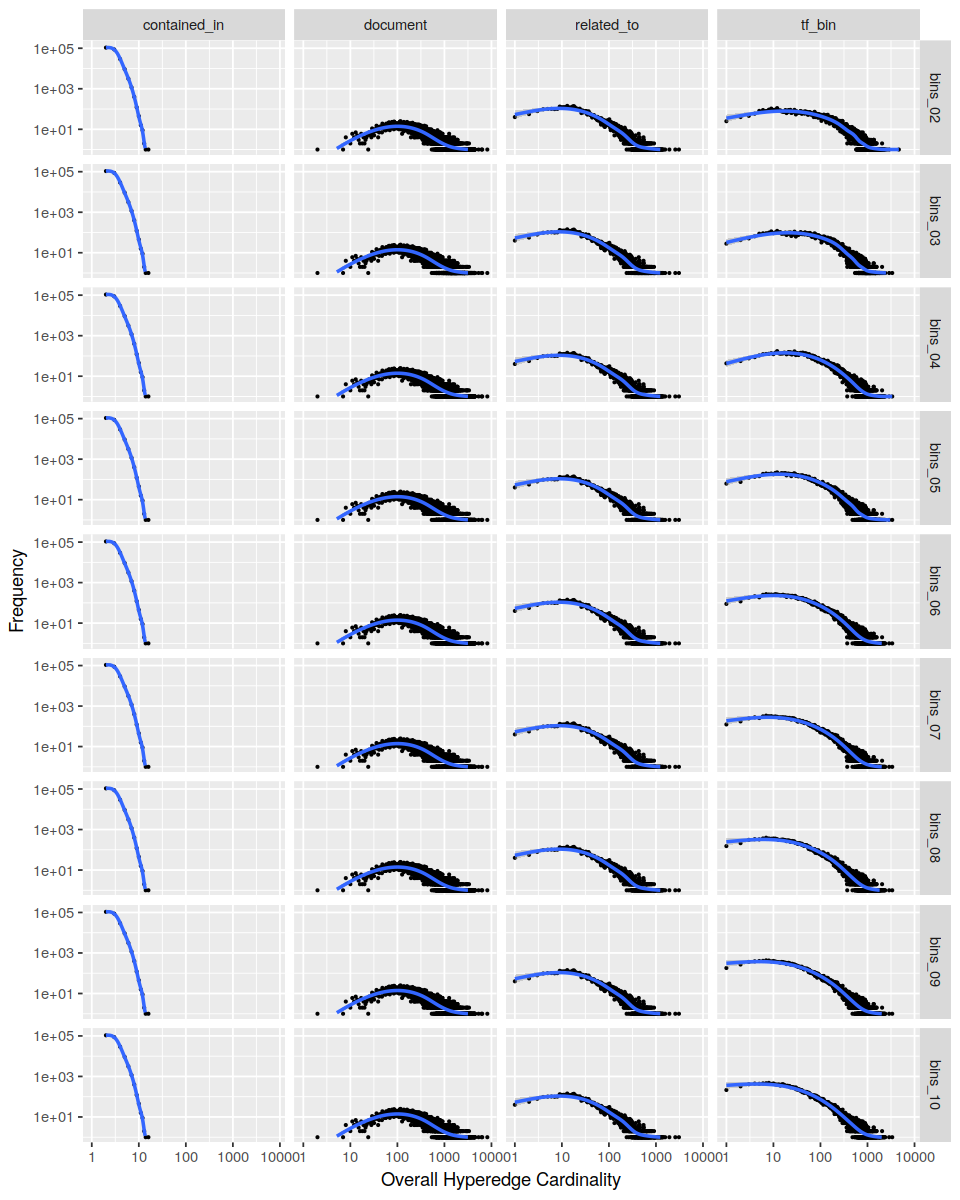

In [219]:
options(repr.plot.width=8, repr.plot.height=10)
plot_degree_per_type(edge_cardinality, "Overall Hyperedge Cardinality", "cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/tf_bins/hyperedge_overall_cardinality.png", width = 8, height = 10, dpi = 300)

#### Hyperedge cardinality distribution based on directed hyperedges

If we only consider directed hyperedges, the tail cardinality has the following non-power-law distribution.

In [222]:
options(repr.plot.width=3.25, repr.plot.height=10)

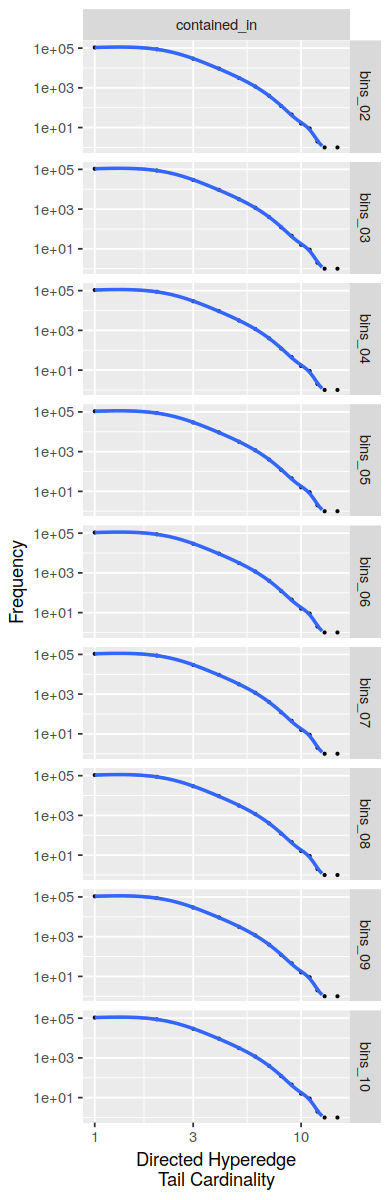

In [223]:
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge\nTail Cardinality", "tail_cardinality") +
    #scale_x_continuous() +
    #scale_y_continuous() +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

For directed hyperedges, the head cardinality is always one.

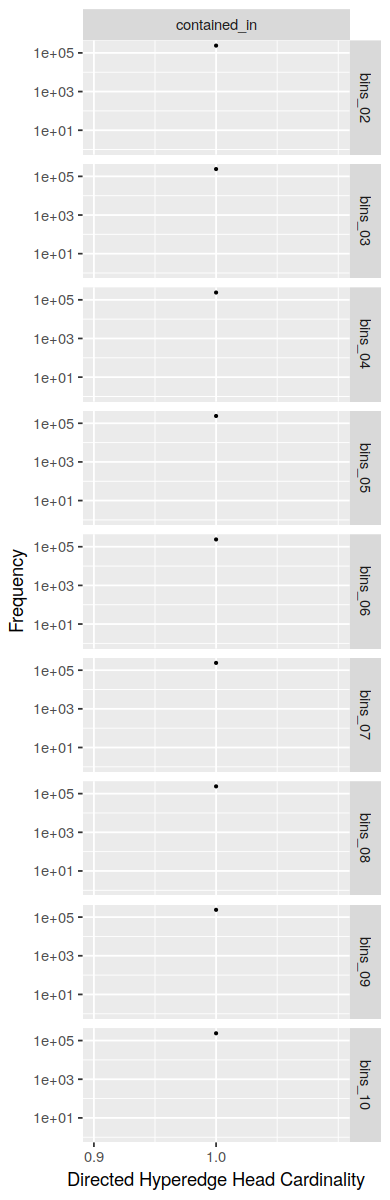

In [224]:
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge Head Cardinality", "head_cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

## Top 10 nodes

### Node incoming-node degree

In [232]:
top_10_terms_by_incoming_node_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(bin_id, node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(bin_id, desc(in_v_degree)) %>%
    group_by(bin_id) %>%
    group_map(~head(.x, 10))
top_10_terms_by_incoming_node_degree

node_id,name,in_v_degree
<int>,<chr>,<int>
458,also,537951
577,new,522929
525,on,512256
770,first,509026
857,time,492091
847,refer,484452
1595,see,482742
762,state,478662
842,link,475903


In [233]:
top_10_entities_by_incoming_node_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(bin_id, node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(bin_id, desc(in_v_degree)) %>%
    group_by(bin_id) %>%
    group_map(~head(.x, 10))
top_10_entities_by_incoming_node_degree

node_id,name,in_v_degree
<int>,<chr>,<int>
2323,United States,199796
300,India,174817
275,Japan,154539
9006,France,146492
4007,2007,136161
8735,World War II,134358
4367,Germany,133949
3992,2006,130566
92,Russia,126066


### Node incoming-hyperedge degree

In [235]:
top_10_terms_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(bin_id, node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    group_by(bin_id) %>%
    group_map(~head(.x, 10))
top_10_terms_by_incoming_hyperedge_degree

node_id,name,in_e_degree
<int>,<chr>,<int>
458,also,10768
847,refer,9400
842,link,9114
841,extern,8928
525,on,8838
577,new,8398
770,first,8186
857,time,8014
1595,see,7992


In [236]:
top_10_entities_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(bin_id, node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    group_by(bin_id) %>%
    group_map(~head(.x, 10))
top_10_entities_by_incoming_hyperedge_degree

node_id,name,in_e_degree
<int>,<chr>,<int>
2323,United States,1984
4238,Scientific classification,1596
300,India,1587
275,Japan,1205
4216,Dinosaur,1129
4007,2007,1009
3992,2006,1005
9006,France,984
4367,Germany,922


## Global statistics

In [22]:
load_stats_data <- function(base_dir, as_list=FALSE) {
    stats_path <- file.path(base_dir, list.files(path = base_dir, pattern = "stats-.*\\.csv"))

    stats <- read.csv(stats_path, stringsAsFactors = F)
    
    stats
}

In [23]:
stats <- rbind(
    load_stats_data(file.path(base_dir, "global")),
    data.frame(
        Statistic=c(
            "Term Vertices",
            "Entity Vertices",
            "contained_in Hyperedges",
            "document Hyperedges",
            "related_to Hyperedges"
        ),
        Value=c(
            nrow(node_degree[node_degree$type == "term", ]),
            nrow(node_degree[node_degree$type == "entity", ]),
            nrow(edge_cardinality[edge_cardinality$type == "contained_in", ]),
            nrow(edge_cardinality[edge_cardinality$type == "document", ]),
            nrow(edge_cardinality[edge_cardinality$type == "related_to", ])
        )
    ))
stats
#print(xtable(stats, digits = 10))

Statistic,Value
<chr>,<dbl>
Vertices,6.072130e+05
Directed Hyperedges,2.382160e+05
Undirected Hyperedges,1.493800e+04
Total Hyperedges,2.531540e+05
Num Sources,0.000000e+00
Num Sinks,0.000000e+00
Density,3.881173e-06
Avg. Degree,8.338227e-01
Min InEdge Degree,1.000000e+00


## Scalability

In order to better understand the impact of adding more documents and entities to the index, we created several snapshots by limiting the number of documents read from INEX 2009 3T-NL subset test collection. We then obtained the following aggregated statistics from each snapshot studying their evolution for an increasing number of documents:

- Average node degree;
 - Average node incoming edge degree;
 - Average node outgoing edge degree;
 - Average node incoming node degree;
 - Average node outgoing node degree;
- Average hyperedge cardinality;
 - Average cardinality for undirected hyperedges;
 - Average tail cardinality for directed hyperedges;
 - Average head cardinality for directed hyperedges;
- Estimated clustering coefficient;
- Estimated average path length and diameter;
- General mixed hypergraph density;
- Size and space usage;
 - Number of nodes;
 - Number of hyperedges;
 - Number of bytes in disk;
 - Number of bytes in memory.

We will begin by the node and hyperedge degree. In order to generate the required data, run the scripts in `runs/inex-2009-3t-nl/hgoe/scalability` in order. This will generate indices with a progressively larger number of documents, using the `--limit` argument (snapshots). Inspect will then generate the node and edge degree distributions per index snapshot, properly organizing them in a directory with name `snapshot_<id>_<num_docs>`.

In [24]:
options(repr.plot.width=4, repr.plot.height=2)

In [25]:
load_snapshots_degree_data <- function(base_dir, type="node") {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call(
                paste("load", type, ifelse(type == "node", "degree", "cardinality"), "data", sep="_"),
                list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [26]:
snapshot_node_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="node")
head(snapshot_node_degree)

snapshot_name,snapshot_id,num_docs,node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree
<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
snapshot_001_1,001,1,0,entity,Cochrane Theatre,123,2,123,123,2,2,0,0,0,0
snapshot_001_1,001,1,1,entity,Cochrane (disambiguation),123,1,123,123,1,1,0,0,0,0
snapshot_001_1,001,1,2,entity,"Cochrane, Wisconsin",123,3,123,123,3,2,1,0,1,0
snapshot_001_1,001,1,3,entity,"Cochrane, Chile",123,3,123,123,3,2,1,0,1,0
snapshot_001_1,001,1,4,entity,Zefram Cochrane,123,3,123,123,3,2,1,0,1,0
snapshot_001_1,001,1,5,entity,Kuala Lumpur,123,3,123,123,3,2,2,0,1,0


In [27]:
snapshot_edge_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="edge")
head(snapshot_edge_degree)

snapshot_name,snapshot_id,num_docs,edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality
<fct>,<fct>,<dbl>,<int>,<chr>,<lgl>,<int>,<int>,<int>,<int>
snapshot_001_1,001,1,0,document,FALSE,123,123,0,0
snapshot_001_1,001,1,1,related_to,FALSE,28,28,0,0
snapshot_001_1,001,1,2,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,3,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,4,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,5,contained_in,TRUE,3,0,2,1


In [28]:
plot_degree_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(mean=mean(!!sym(stat), na.rm=TRUE))

    ggplot(data, aes(x=num_docs, y=mean)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}
                      
plot_size_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(len=length(!!sym(stat)))

    ggplot(data, aes(x=num_docs, y=len)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

### Average node degree

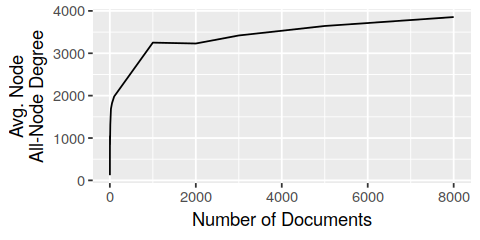

In [29]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Node Degree", stat = "v_degree")
ggsave(filename = "output/tf_bins/snapshot_average_all_node_degree.png", width = 4, height = 2, dpi = 300)

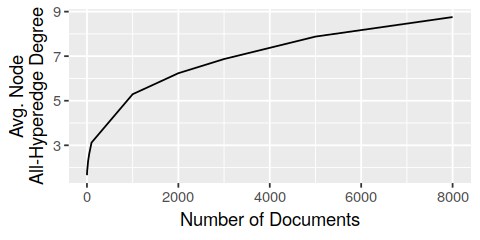

In [30]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Hyperedge Degree", stat = "e_degree")
ggsave(filename = "output/tf_bins/snapshot_average_all_hyperedge_degree.png", width = 4, height = 2, dpi = 300)

#### Average node degree based on directed hyperedges

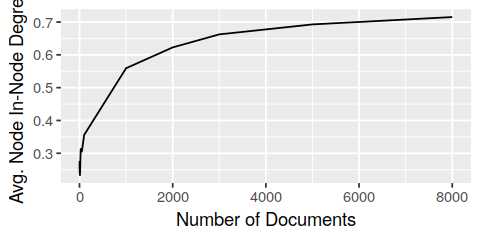

In [31]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Node Degree", stat = "dir_in_v_degree")

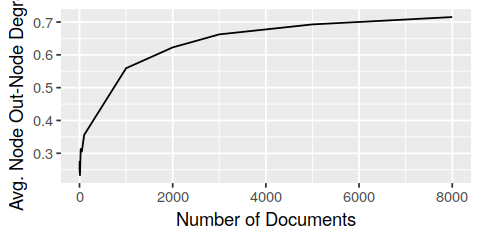

In [32]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Node Degree", stat = "dir_out_v_degree")

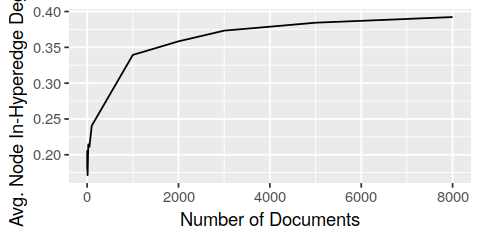

In [33]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Hyperedge Degree", stat = "dir_in_e_degree")

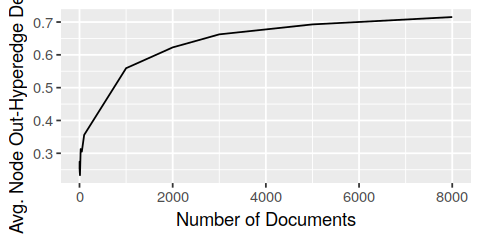

In [34]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Hyperedge Degree", stat = "dir_out_e_degree")

### Average hyperedge cardinality

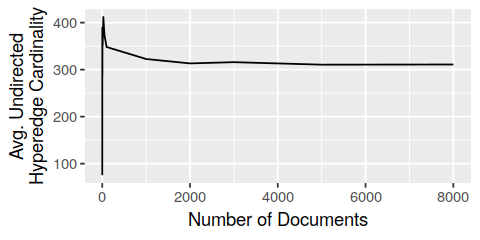

In [35]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(!is_directed), "Avg. Undirected\nHyperedge Cardinality", stat = "cardinality")
ggsave(filename = "output/tf_bins/snapshot_average_hyperedge_cardinality.png", width = 4, height = 2, dpi = 300)

In [36]:
snapshot_edge_degree %>%
    filter(!is_directed) %>%
    group_by(num_docs) %>%
    summarise(mean=mean(cardinality, na.rm = TRUE))

num_docs,mean
<dbl>,<dbl>
1,75.5000
2,389.2500
3,347.3333
4,288.2500
5,360.4000
10,352.0000
25,411.8800
50,373.8700
100,348.1150


#### Average directed hyperedge cardinalities

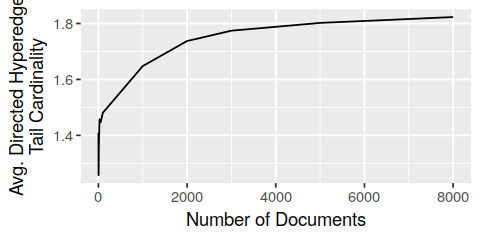

In [37]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed),
    "Avg. Directed Hyperedge\nTail Cardinality",
    stat = "tail_cardinality")

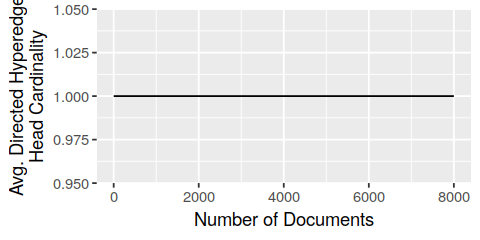

In [38]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed),
    "Avg. Directed Hyperedge\nHead Cardinality",
    stat = "head_cardinality")

### Estimated clustering coefficient

In [39]:
load_snapshots_stats_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call("load_stats_data", list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    
    setNames(data, c(names(data)[1:3], "statistic", "value"))
}

In [40]:
snapshot_stats <- load_snapshots_stats_data(file.path(base_dir, "snapshots"))
head(snapshot_stats)

snapshot_name,snapshot_id,num_docs,statistic,value
<fct>,<fct>,<dbl>,<chr>,<dbl>
snapshot_001_1,001,1,Vertices,123
snapshot_001_1,001,1,Directed Hyperedges,22
snapshot_001_1,001,1,Undirected Hyperedges,2
snapshot_001_1,001,1,Total Hyperedges,24
snapshot_001_1,001,1,Num Sources,0
snapshot_001_1,001,1,Num Sinks,0


In [41]:
plot_statistics_over_time <- function(data, label, log_scale=FALSE, legend_position = c(0.565, 0.8)) {
    if (length(unique(data$statistic)) > 1) {
        p <- ggplot(data, aes(x=num_docs, y=value, color=statistic)) +
            scale_color_manual("Statistic", values=c("#9673a6", "#82b366")) +
            theme(
                legend.position=legend_position,
                legend.direction="horizontal")
    } else {
        p <- ggplot(data, aes(x=num_docs, y=value))
    }
    
    if (log_scale) {
        p <- p + scale_x_log10() + scale_y_log10()
    }
    
    p + geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

In [42]:
snapshot_cc <- snapshot_stats[which(snapshot_stats$statistic == "Avg. Clustering Coefficient"), ]
snapshot_cc

,snapshot_name,snapshot_id,num_docs,statistic,value
,<fct>,<fct>,<dbl>,<chr>,<dbl>
17,snapshot_001_1,001,1,Avg. Clustering Coefficient,0.5869933
36,snapshot_002_2,002,2,Avg. Clustering Coefficient,0.5592256
55,snapshot_003_3,003,3,Avg. Clustering Coefficient,0.5491855
74,snapshot_004_4,004,4,Avg. Clustering Coefficient,0.5472917
93,snapshot_005_5,005,5,Avg. Clustering Coefficient,0.4984415
112,snapshot_006_10,006,10,Avg. Clustering Coefficient,0.4746736
131,snapshot_007_25,007,25,Avg. Clustering Coefficient,0.3865079
150,snapshot_008_50,008,50,Avg. Clustering Coefficient,0.3230005
169,snapshot_009_100,009,100,Avg. Clustering Coefficient,0.2641110


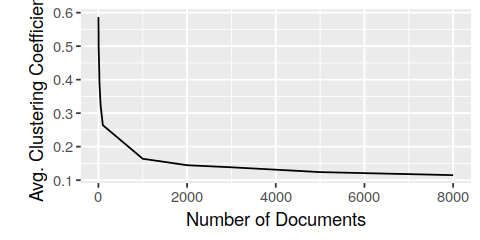

In [43]:
plot_statistics_over_time(snapshot_cc, "\nAvg. Clustering Coefficient")
ggsave(filename = "output/tf_bins/snapshot_avg_clustering_coefficient.png", width = 4, height = 2, dpi = 300)

### Estimated average path length and diameter

In [44]:
snapshot_paths <- snapshot_stats[which(snapshot_stats$statistic %in% c("Avg. Path Length", "Diameter")), ]
snapshot_paths %>% filter(statistic == "Diameter")
snapshot_paths %>% filter(statistic == "Avg. Path Length")

snapshot_name,snapshot_id,num_docs,statistic,value
<fct>,<fct>,<dbl>,<chr>,<dbl>
snapshot_001_1,001,1,Diameter,491
snapshot_002_2,002,2,Diameter,10
snapshot_003_3,003,3,Diameter,9
snapshot_004_4,004,4,Diameter,9
snapshot_005_5,005,5,Diameter,8
snapshot_006_10,006,10,Diameter,10
snapshot_007_25,007,25,Diameter,12
snapshot_008_50,008,50,Diameter,13
snapshot_009_100,009,100,Diameter,14


snapshot_name,snapshot_id,num_docs,statistic,value
<fct>,<fct>,<dbl>,<chr>,<dbl>
snapshot_001_1,001,1,Avg. Path Length,126.066666
snapshot_002_2,002,2,Avg. Path Length,3.766667
snapshot_003_3,003,3,Avg. Path Length,4.066667
snapshot_004_4,004,4,Avg. Path Length,3.700000
snapshot_005_5,005,5,Avg. Path Length,4.200000
snapshot_006_10,006,10,Avg. Path Length,4.533333
snapshot_007_25,007,25,Avg. Path Length,5.533333
snapshot_008_50,008,50,Avg. Path Length,6.533333
snapshot_009_100,009,100,Avg. Path Length,7.100000


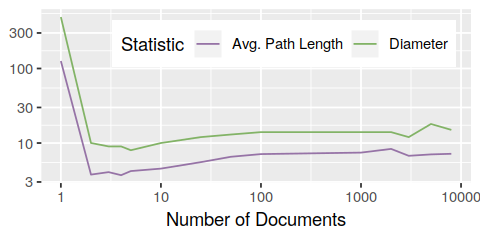

In [45]:
plot_statistics_over_time(snapshot_paths, NULL, log_scale = TRUE)
ggsave(filename = "output/tf_bins/snapshot_avg_shortest_path_stats.png", width = 4, height = 2, dpi = 300)

### General mixed hypergraph density

In [46]:
snapshot_density <- snapshot_stats[which(snapshot_stats$statistic == "Density"), ]
snapshot_density

,snapshot_name,snapshot_id,num_docs,statistic,value
,<fct>,<fct>,<dbl>,<chr>,<dbl>
7,snapshot_001_1,001,1,Density,1.374522e-03
26,snapshot_002_2,002,2,Density,1.401240e-04
45,snapshot_003_3,003,3,Density,1.047619e-04
64,snapshot_004_4,004,4,Density,9.483004e-05
83,snapshot_005_5,005,5,Density,6.345873e-05
102,snapshot_006_10,006,10,Density,3.428081e-05
121,snapshot_007_25,007,25,Density,1.582643e-05
140,snapshot_008_50,008,50,Density,1.059882e-05
159,snapshot_009_100,009,100,Density,7.659471e-06


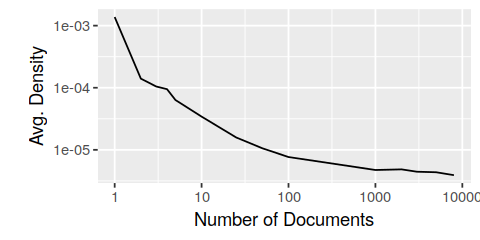

In [47]:
plot_statistics_over_time(snapshot_density, "\nAvg. Density", log_scale = TRUE)
ggsave(filename = "output/tf_bins/snapshot_avg_density.png", width = 4, height = 2, dpi = 300)

### Size and space usage

#### Number of nodes and hyperedges

The growth in number of nodes is sublinear in regard to the number of documents.

In [67]:
snapshot_node_degree %>%
        group_by(num_docs) %>%
        summarize(len=length(node_id))

num_docs,len
<dbl>,<int>
1,123
2,1217
3,1559
4,1702
5,2497
10,4566
25,11725
50,17769
100,27582


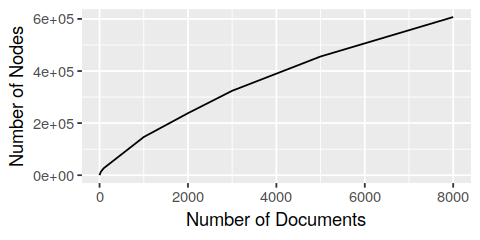

In [48]:
plot_size_over_time(snapshot_node_degree, "Number of Nodes", stat = "node_id")
ggsave(filename = "output/tf_bins/snapshot_num_nodes.png", width = 4.5, height = 2, dpi = 300)

Similarly, the growth in number of hyperedges is sublinear in regard to the number of documents, although there are significantly less hyperedges than nodes.

In [66]:
snapshot_edge_degree %>%
        group_by(num_docs) %>%
        summarize(len=length(edge_id))

num_docs,len
<dbl>,<int>
1,24
2,254
3,317
4,342
5,490
10,803
25,2567
50,3849
100,6831


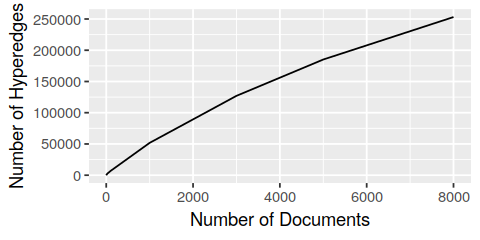

In [49]:
plot_size_over_time(snapshot_edge_degree, "Number of Hyperedges", stat = "edge_id")
ggsave(filename = "output/tf_bins/snapshot_num_hyperedges.png", width = 4.5, height = 2, dpi = 300)

#### Number of bytes in disk and memory

In [50]:
load_snapshots_space_usage_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            read.csv(file.path(snapshot_dir, list.files(path = snapshot_dir, pattern = "space-usage-.*\\.csv"))))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [51]:
snapshot_space <- load_snapshots_space_usage_data(file.path(base_dir, "snapshots"))
snapshot_space

snapshot_name,snapshot_id,num_docs,Statistic,Value
<fct>,<fct>,<dbl>,<fct>,<dbl>
snapshot_001_1,001,1,Disk (Bytes),44857
snapshot_001_1,001,1,Memory (Bytes),1089921536
snapshot_002_2,002,2,Disk (Bytes),303211
snapshot_002_2,002,2,Memory (Bytes),1089921536
snapshot_003_3,003,3,Disk (Bytes),384076
snapshot_003_3,003,3,Memory (Bytes),1089921520
snapshot_004_4,004,4,Disk (Bytes),416798
snapshot_004_4,004,4,Memory (Bytes),1089954232
snapshot_005_5,005,5,Disk (Bytes),602249


In [52]:
snapshot_space %>%
    filter(Statistic == "Disk (Bytes)") %>%
    summarise(Mean=mean(Value), StdDev=sd(Value)) %>%
    mutate(Mean=paste(round(Mean / 1024^2, 1), "MiB"), StdDev=paste(round(StdDev / 1024^2, 1), "MiB"))

snapshot_space %>%
    filter(Statistic == "Memory (Bytes)") %>%
    summarise(Mean=mean(Value), StdDev=sd(Value)) %>%
    mutate(Mean=paste(round(Mean / 1024^3, 1), "GiB"), StdDev=paste(round(StdDev / 1024^2, 1), "MiB"))

Mean,StdDev
<chr>,<chr>
37.5 MiB,58.9 MiB


Mean,StdDev
<chr>,<chr>
1.3 GiB,461.1 MiB


In [53]:
plot_space_usage <- function(data, label, stat = "Disk (Bytes)", unit="MB") {
    data <- data %>% filter(Statistic == stat)
    
    stopifnot(unit %in% c("B", "KB", "MB", "GB", "TB"))
    
    if (unit == "B") {
        frac <- 1
    } else if (unit == "KB") {
        frac <- 1024
    } else if (unit == "MB") {
        frac <- 1024^2
    } else if (unit == "GB") {
        frac <- 1024^3
    } else if (unit == "TB") {
        frac <- 1024^4
    }
    
    ggplot(data, aes(x = num_docs, y = Value / frac)) +
        geom_line() +
        scale_y_continuous(label = function(s) paste(s, unit)) +
        xlab("Number of Documents") +
        ylab(label)
}

The growth in disk space is sublinear in regard to the number of documents.

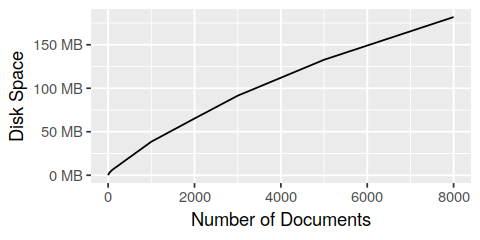

In [54]:
plot_space_usage(snapshot_space, "Disk Space", stat = "Disk (Bytes)")
ggsave(filename = "output/tf_bins/snapshot_disk_space.png", width = 4.5, height = 2, dpi = 300)

The growth in memory space is sublinear in regard to the number of documents, presenting a sharper growth for the first 1000 documents.

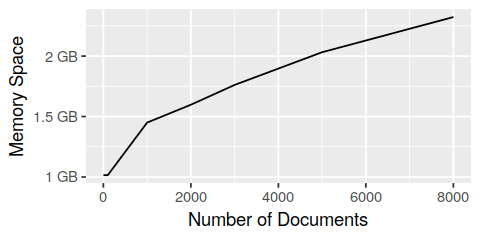

In [55]:
plot_space_usage(snapshot_space, "Memory Space", stat = "Memory (Bytes)", unit = "GB")
ggsave(filename = "output/tf_bins/snapshot_mem_space.png", width = 4.5, height = 2, dpi = 300)